### Interpretability - feature metrics

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
coral_df = pd.read_csv("/work/hs325/coral/data/corals.csv")
met_df = pd.read_csv("/work/hs325/coral/data/metabolites.csv")
coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')

X = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
y = coral_df['scleractinia']
X = X.to_numpy()
y = y.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

/tmp/ipykernel_2719028/4072942599.py:1: DtypeWarning: Columns (3,12) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/coral/data/corals.csv")


accuracy 0.9833
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       1.00      0.98      0.99        89

    accuracy                           0.98       120
   macro avg       0.97      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



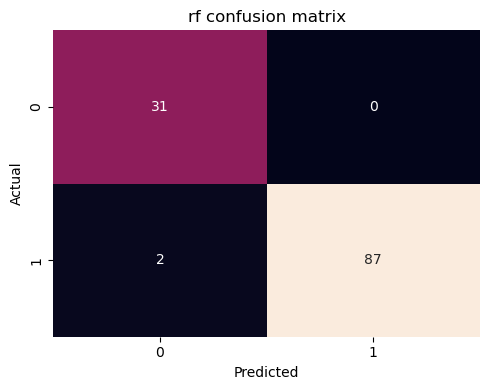

In [4]:
# RF best params =  OrderedDict({'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 595})
rf_path = "/work/hs325/coral/models/scleractinia_coralall/RF_best_model.joblib"
rf = joblib.load(rf_path)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("rf confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


accuracy 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        89

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



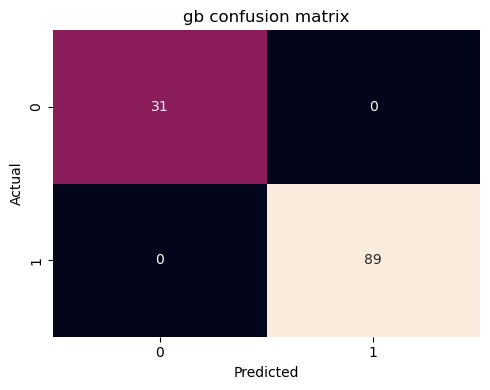

In [5]:
gb_path = "/work/hs325/coral/models/scleractinia_coralall/GB_best_model.joblib"
gb = joblib.load(gb_path)
y_pred = gb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("gb confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


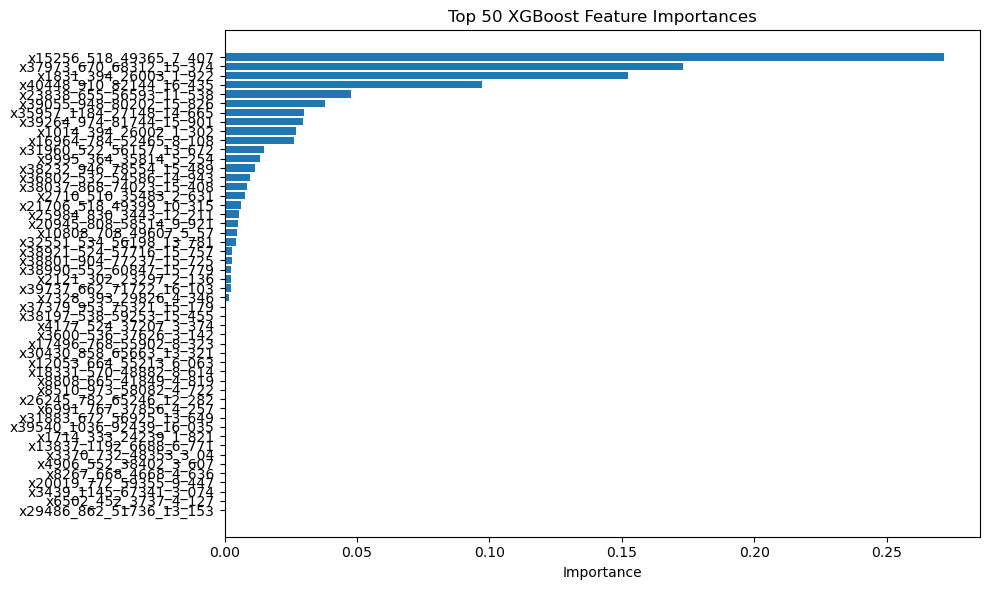

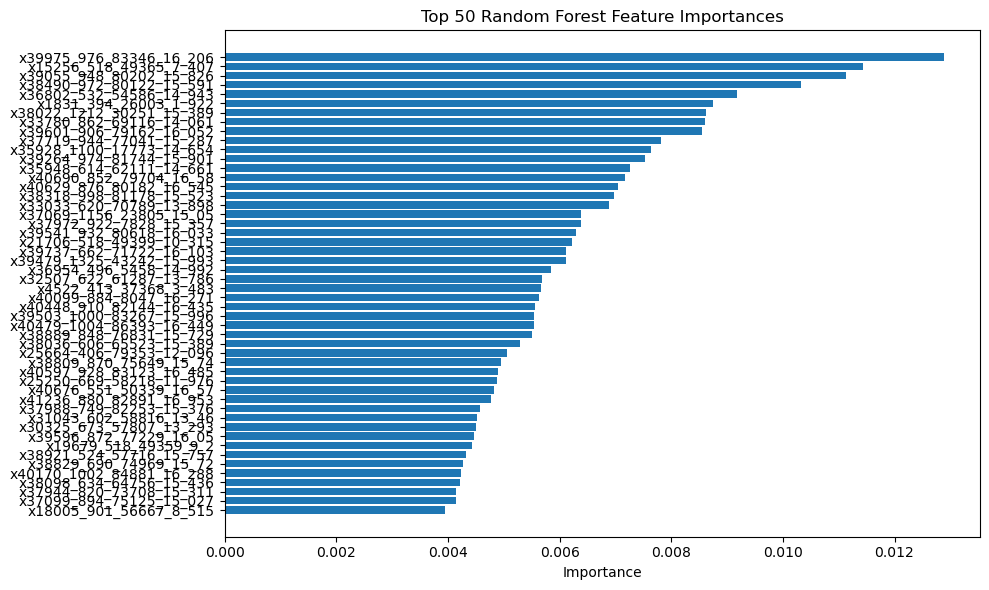

In [7]:
feature_names = coral_df.columns.intersection(met_df['metabolite'])

def get_feature_importances_df(gb_importances, rf_importances, feature_names):
    
    gb_df = pd.DataFrame({
        'Feature': feature_names,
        'XGBoost_Importance': gb_importances
    })

    rf_df = pd.DataFrame({
        'Feature': feature_names,
        'RandomForest_Importance': rf_importances
    })

    merged_df = pd.merge(gb_df, rf_df, on='Feature', how='outer')
    
    merged_df = merged_df.set_index('Feature')
    merged_df['Total_Importance'] = merged_df['XGBoost_Importance'] + merged_df['RandomForest_Importance']
    merged_df = merged_df.sort_values(by='Total_Importance', ascending=False)
    merged_df = merged_df.drop(columns=['Total_Importance'])
    return merged_df

def plot_top_features(importances, feature_names, title, top_n=50):
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = np.array(feature_names)[indices]
    top_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importances[::-1])
    plt.yticks(range(len(top_features)), top_features[::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

feature_importance_comparison_df = get_feature_importances_df(
    gb.feature_importances_, 
    rf.feature_importances_, 
    feature_names
)

plot_top_features(gb.feature_importances_, feature_names, "Top 50 XGBoost Feature Importances", top_n=50)
plot_top_features(rf.feature_importances_, feature_names, "Top 50 Random Forest Feature Importances", top_n=50)

In [8]:
feature_importance_comparison_df.to_csv("featureimportancedec2.csv")

### Explainability metrics - SHAP/ALE


In [ ]:
original_cols = feature_importance_comparison_df.columns.tolist()
met_df_indexed = met_df.set_index('metabolite')
merged_df = feature_importance_comparison_df.merge(
    met_df_indexed,
    left_index=True,
    right_index=True,
    how='inner'
)
merged_df

,XGBoost_Importance,RandomForest_Importance,feature_id,compound_superclass,molecular_formula,adduct,precursor_formula,npc_number_pathway,npc_number_pathway_probability,npc_number_superclass,...,coraldb_mz_error_ppm,coraldb_compound_family,coraldb_compound_superclass,coraldb_compound_class,exact_mass,database,clusterIndex,refined_origin,compound_class,coraldb_compound_name
x15256_518_49365_7_407,0.271587,0.011427,15256,Sphingolipids,C34H63NO2,[M + H]+,C34H63NO2,Fatty acids,0.983569,Sphingolipids,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coral,Ceramides,NaN
x37973_670_68312_15_374,0.173231,0.002451,37973,Unknown,NaN,NaN,NaN,Unknown,NaN,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN
x1831_394_26003_1_922,0.152286,0.008746,1831,Unknown,C17H31BN6O4,[M + H]+,C17H31BN6O4,Unknown,0.784776,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Symbiont,Unknown,NaN
x40448_910_82144_16_435,0.097131,0.005563,40448,Monoalkyldiacylglycerols,NaN,NaN,NaN,Unknown,NaN,Unknown,...,1.67528,Glycerolipid,Monoalkyldiacylglycerols,MADAG,910.822935,KARP,238567.0,Coral,MADAG,MADAG(56:6) [M+NH4]+
x39055_948_80202_15_826,0.037715,0.011126,39055,Triacylglycerols,C59H107NO6,[M + Na]+,C59H107NO6,Fatty acids,0.999973,Glycerolipids,...,2.18718,Glycerolipid,Triacylglycerols,Triacylglycerols,948.799900,Niarox,115374.0,Both,Triacylglycerols,TAG(18:1/18:1/22:6) / (18:0/20:4/20:4) / (18:1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x21816_745_59121_10_372,0.000000,0.000000,21816,Unknown,NaN,NaN,NaN,Unknown,NaN,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Symbiont,Unknown,NaN
x21817_804_58699_10_362,0.000000,0.000000,21817,Glycerophospholipids,C45H84NO7P,[M + Na]+,C45H84NO7P,Fatty acids,0.999640,Glycerophospholipids,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coral,Glycerophosphoethanolamines,NaN
x2181_205_19523_2_201,0.000000,0.000000,2181,Sesquiterpenoids,C15H24,[M + H]+,C15H24,Terpenoids,0.997447,Sesquiterpenoids,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN
x21823_830_54629_10_378,0.000000,0.000000,21823,Unknown,C37H71N11O10,[M + H]+,C37H71N11O10,Amino acids and Peptides,0.878915,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coral,Unknown,NaN


GB best params =  OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 558, 'subsample': 0.5})

RF best params =  OrderedDict({'max_depth': 39, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 343})


In [45]:
import shap
# from PyALE import ale
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import effector
import lime
from anchor import anchor_tabular


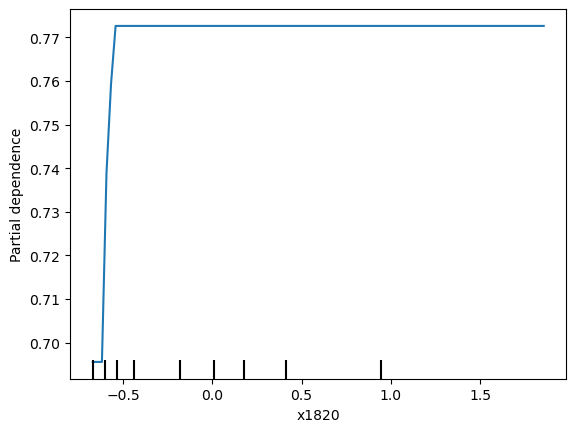

In [ ]:
features = [1820]
## must retrain models using feature indices - input the top features from merged_df and make PDPs/ALEs

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(gb, X_test, features, kind='average') #kind='both'

## run ALE plot for this feature


In [ ]:
## may have to run this on cluster

perm_imp = permutation_importance(gb, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")


In [ ]:
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [ ]:
## Anchor

## must debug
class_names = ['<=50K', '>50K']

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values,
)
idx = 100

exp = explainer.explain_instance(X_test.values[idx], gb.predict, threshold=0.80)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())


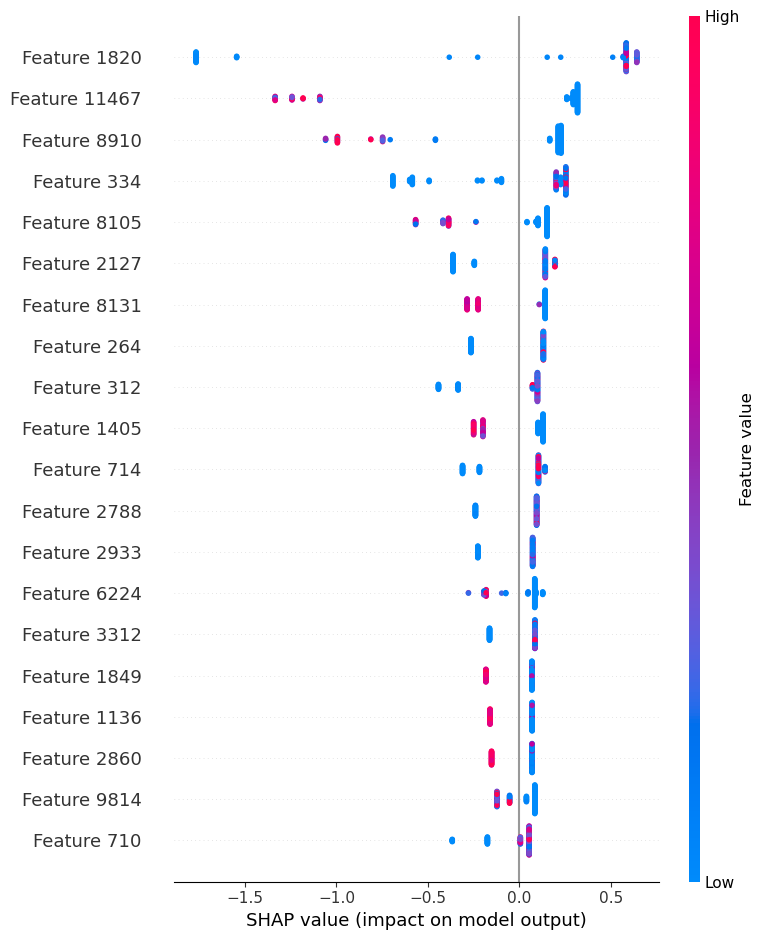

In [47]:
## Shap
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(gb, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test
shap.summary_plot(shap_values, X_test)



In [53]:
feature_name_df = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
feature_name_df.iloc[:,1820]

0      50029.810
1      12667.683
2      68022.780
3      50144.520
4      93021.980
         ...    
592    12680.457
593        0.000
594    10123.123
595    17453.530
596    17232.861
Name: x15256_518_49365_7_407, Length: 597, dtype: float64

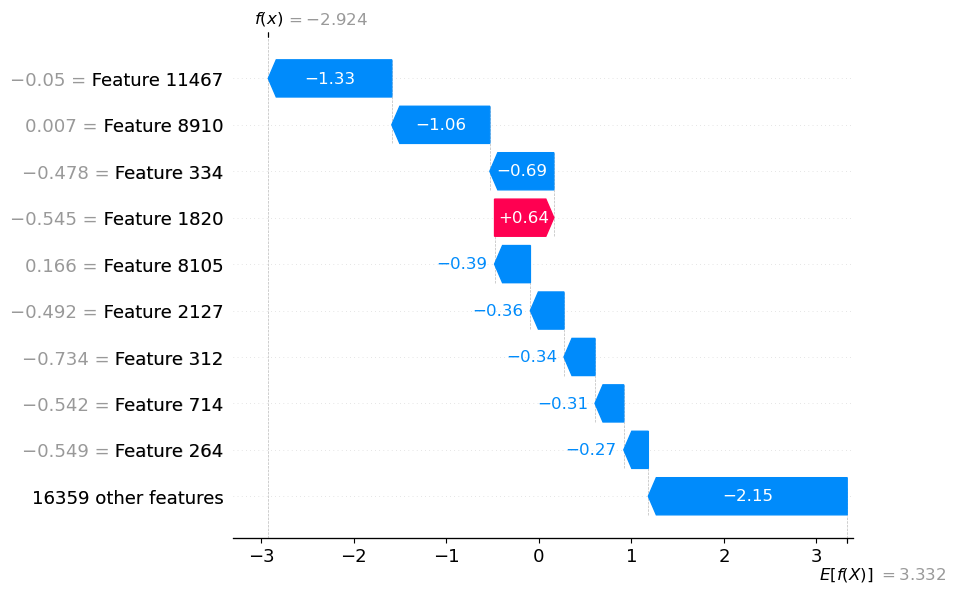

In [ ]:
idx = 100
shap.plots.waterfall(shap_values_exp[idx])